# Description
I will use several deep learning models for my time series predictions. 
* LSTM
* Transformer
* dialated CNN

In all cases I will include daily snowfall as an exogenous variable.

## Environment
For $ reasons I will use Colab

In [25]:
# get colab status
try:
    import google.colab
    IN_COLAB = True
    %tensorflow_version 2.x
except:
    IN_COLAB = False

In [26]:
# data wrangling
import numpy as np
import pandas as pd
import os.path

# viz
import altair as alt
import matplotlib.pyplot as plt
%matplotlib inline
from vapeplot import vapeplot
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

In [47]:
# local code with hack to avoid cloing full repo each time colab is run
if IN_COLAB:
    projectcode = r"https://github.com/chrisoyer/ski-snow-modeling/blob/master/src/analysis/project_utils/project_utils.py"
    ! wget $projectcode
from project_utils.project_utils import *

In [28]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import RootMeanSquaredError as rmse
from tensorflow.keras.callbacks import EarlyStopping

# Parameters

In [29]:
alt.renderers.enable(embed_options={'theme': 'vox'})
alt.data_transformers.disable_max_rows()
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
plt.rc('figure', figsize=(11.0, 7.0))
batch_size = 15
logs_path = "./logs/visualize_graph"

lookback = 30  # days prior to use for prediction

# Plotting Functions

In [67]:
# todo: fix function in util to work for SM or TF
def y_and_yhat_plotter(model=None, data=None, test_data=None, steps=5, 
                       start_skip=1, include_interval=True):
    """plots values and model predictions
    Inputs:
        model: a fitted model with predict method
        data: df with time series data and pseudo_ts index
        test_data: out of sample data
        exog_col: column name
        steps: steps out to predict
        include_interval: bool if include prediction confidence interval"""
    # copy for both plots
    model_multi = model
    df = multi_df = data.rename(columns={'base': 'y'})
    test_df = test_multi_df = test_data.rename(columns={'base': 'y'})
    
    #get prediction for both train & test
    df = np.concatenate([df, test_df], axis=0)
    #check model type TF vs SM

    modelkwgs = multikwgs = {}
    df['yhat'] = model.predict(df)
    if include_interval:
        df['lowerCI'] = model.prediction_ci.iloc[:, 0]
        df['upperCI'] = model.prediction_ci.iloc[:, 1]
    test_multi_df['yhat'] = model_multi.predict(test_multi_df, **multikwgs)
    if include_interval:
        test_multi_df['lowerCI'] = model_multi.prediction_ci.iloc[:, 0]
        test_multi_df['upperCI'] = model_multi.prediction_ci.iloc[:, 1]
    
    multi_df = pd.concat([multi_df, test_multi_df])

    # skip first value: predictions are based on prior values
    df2, multi2_df = df.iloc[start_skip:, :], multi_df.iloc[start_skip:, :]

    def melt_predicts(df):
        return (df
                .reset_index()
                .rename(columns={'index': 'pseudo_ts'})
                .melt(value_vars=['y', 'yhat'], id_vars=['pseudo_ts'])
                )
    melted_df2 = melt_predicts(df)
    melted_df_multi2 = melt_predicts(multi_df)

    fig, axes = plt.subplots(2, 1, figsize=(18, 6), sharex=True)

    def plot_sub(y, ci_data, axis):
        sns.lineplot(data=y, x='pseudo_ts', y='value', hue='variable',
                     marker='x', ax=axis)
        if include_interval:
            axis.fill_between(ci_data.index, ci_data.lowerCI,
                              ci_data.upperCI, alpha=.3)
    data = (df2, multi2_df)
    melted_data = (melted_df2, melted_df_multi2)
    for datum, melted_datum, axis in zip(data, melted_data, axes):
        plot_sub(y=melted_datum, ci_data=datum, axis=axis)
    axes[0].set_title("One Step Prediction over Train & Test")
    axes[1].set_title("Recursive Prediction on Test Set")

# Load Data

In [30]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.chdir(r'/content/gdrive/My Drive/data_sci/colab_datasets/ski/')
    all_data_path = r'./data/snow_data_clean.parquet'
    mirrored_strategy = tf.distribute.MirroredStrategy()
else:
    all_data_path = r'../../data/snow_data_clean.parquet'
!pwd

/c/Users/User/Documents/GitHub/ski-snow-modeling/src/analysis


In [31]:
snow_df = pd.read_parquet(all_data_path)

### Reshape for TF input
Shape should match (__samples__, __time steps__, __features__)

In [32]:
def data_slim(source=snow_df, station=None, region=None):
    """filters data for station OR region, relevant features, and returns np"""
    if station:
        source = source.query('station==@station')
    if region:
        source = source.query('region==@region')

    data_arr = (source
                .reset_index()
                [['base', 'dayofyr', 'snowfall']]
                .to_numpy()
                )
    return data_arr

In [72]:
# scale data
def scaler(X):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(X)
    scaled_X = scaler.transform(X)

    # invert transform
    inverted_X = scaler.inverse_transform(scaled_X)
    return scaled_X, scaler

In [76]:
copper = data_slim(station="Copper Mountain")

copper_scaled, copper_scaler = scaler(copper)

In [35]:
def data_split(data=None, test_frac=.2, lookback=lookback, 
               batch_size=batch_size, return_dfs=False):
    """split into train and test sets
    Params:
        data: endogenous should be first col
        test_frac: fraction of data for test
        lookback: prior time units to use for generating prediction
        return_dfs: set to True to return dataframes (for plotting) instead of
                    data generators
    returns: (training, test) data generator or dfs
    """
    data_rows = data.shape[0]
    test_size = int(data_rows * test_frac)
    train_size = data_rows - test_size
    train, test = data[:train_size, :], data[train_size:, :]
    if return_dfs:
        return (pd.DataFrame(train).rename(columns={0:"base", 1:'dayofyr', 2:'snowfall'}), 
                pd.DataFrame(test).rename(columns={0:"base", 1:'dayofyr', 2:'snowfall'}))
    gen_params = {'length': lookback,  # prior samples used for prediction
                  'sampling_rate': 1, 'stride': 1,
                  'batch_size': batch_size}
    train_data_gen = sequence.TimeseriesGenerator(data=train,
                                                  targets=train[:, 0],
                                                  **gen_params)
    test_data_gen = sequence.TimeseriesGenerator(data=test,
                                                 targets=test[:, 0],
                                                 **gen_params)
    return train_data_gen, test_data_gen


Xy_train, Xy_val = data_split(data=copper_scaled)

# Timeseries Modeling

The evolution of snow base depth over time depends (not 1:1; a foot of powder is only a few inches of packed powder) on new snowfall and melting of old snow. I will start by modeling as a simple timeseries, and then include new snowfall as a predictor variable.

## Modeling Setup
I will use supersetting crossvalidation (walk-forward CV) since this is a time series problem.

# TF LSTM models
 

In [36]:
def make_lstm(neurons=None, layers=None, batch_size=None, x_shape=None, lookback=lookback):
    """
    Parameters:
        neurons: width of layers, eg (4,5,6) implies first hidden layer has 4
            neuron, 2nd layer has 5, third layer has 6
        batch size: ...
        x_shape: (rows, features)
    Returns: unfitted model
    """
    input_shape = (lookback, x_shape[1])
    xlayer = inputs = Input(shape=input_shape, batch_size=batch_size)
    lstm_kwargs = dict(units=neurons, batch_input_shape=input_shape,
                           stateful=True, dropout=0.2, recurrent_dropout=0.2,
                           return_sequences=False)
    for layer in range(layers):
        lstm_kwargs['return_sequences'] = False if layer == layers-1 else True
        xlayer = LSTM(**lstm_kwargs)(xlayer)
    outputs = Dense(1)(xlayer)
    model = Model(inputs=inputs, outputs=outputs)
    metrics = ['mean_absolute_error', 'mean_squared_error']
    model.compile(loss="mse", metrics=metrics,
                  optimizer='adam')
    return model


def fit_model(model, X, X_val, batch_size, n_epoch):
    """runs the training; returns model and history"""
    cb = EarlyStopping(monitor='mean_squared_error', patience=3, restore_best_weights=True)
    history = model.fit(X, validation_data=X_val,
                        epochs=n_epoch, batch_size=batch_size,
                        shuffle=False, callbacks=[],
                        verbose=1)
    return model, history

# Vanilla LSTM Model

In [37]:
model_kwg = {'batch_size': batch_size, 'x_shape': copper_scaled.shape,}
modelfit_kwg = {'X': Xy_train, 'X_val': Xy_val, 
                'batch_size': batch_size, 
               'n_epoch': 5}

### 1 layer

In [38]:
lstm_100x1 = make_lstm(neurons=100, layers=1, **model_kwg)
lstm_100x1, lstm_100x1_hst = fit_model(model=lstm_100x1, 
                                       **modelfit_kwg)
lstm_100x1.summary()

Epoch 1/5
154/154 [==============================] - 4s 25ms/step - loss: 0.0600 - mean_absolute_error: 0.1978 - mean_squared_error: 0.0600 - val_loss: 0.0121 - val_mean_absolute_error: 0.0897 - val_mean_squared_error: 0.0121
Epoch 2/5
154/154 [==============================] - 3s 22ms/step - loss: 0.0170 - mean_absolute_error: 0.1033 - mean_squared_error: 0.0170 - val_loss: 0.0071 - val_mean_absolute_error: 0.0681 - val_mean_squared_error: 0.0071
Epoch 3/5
154/154 [==============================] - 3s 22ms/step - loss: 0.0168 - mean_absolute_error: 0.1026 - mean_squared_error: 0.0168 - val_loss: 0.0071 - val_mean_absolute_error: 0.0690 - val_mean_squared_error: 0.0071
Epoch 4/5
154/154 [==============================] - 4s 23ms/step - loss: 0.0158 - mean_absolute_error: 0.1001 - mean_squared_error: 0.0158 - val_loss: 0.0064 - val_mean_absolute_error: 0.0649 - val_mean_squared_error: 0.0064
Epoch 5/5
154/154 [==============================] - 4s 24ms/step - loss: 0.0133 - mean_absolute

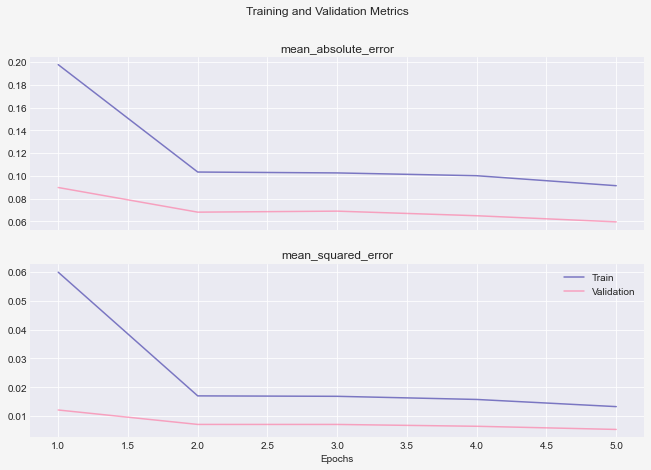

In [39]:
hist_plotter(lstm_100x1_hst.history)

### 2 Layers

In [40]:
lstm_100x2 = make_lstm(neurons=100, layers=2,**model_kwg)
lstm_100x2, lstm_100x2_hst = fit_model(model=lstm_100x2, **modelfit_kwg)
lstm_100x2.summary()

Epoch 1/5
154/154 [==============================] - 9s 55ms/step - loss: 0.0655 - mean_absolute_error: 0.2042 - mean_squared_error: 0.0655 - val_loss: 0.0185 - val_mean_absolute_error: 0.1131 - val_mean_squared_error: 0.0185
Epoch 2/5
154/154 [==============================] - 8s 54ms/step - loss: 0.0202 - mean_absolute_error: 0.1122 - mean_squared_error: 0.0202 - val_loss: 0.0084 - val_mean_absolute_error: 0.0761 - val_mean_squared_error: 0.0084
Epoch 3/5
154/154 [==============================] - 9s 57ms/step - loss: 0.0236 - mean_absolute_error: 0.1187 - mean_squared_error: 0.0236 - val_loss: 0.0381 - val_mean_absolute_error: 0.1652 - val_mean_squared_error: 0.0381
Epoch 4/5
154/154 [==============================] - 10s 67ms/step - loss: 0.0264 - mean_absolute_error: 0.1291 - mean_squared_error: 0.0264 - val_loss: 0.0096 - val_mean_absolute_error: 0.0751 - val_mean_squared_error: 0.0096
Epoch 5/5
154/154 [==============================] - 9s 61ms/step - loss: 0.0151 - mean_absolut

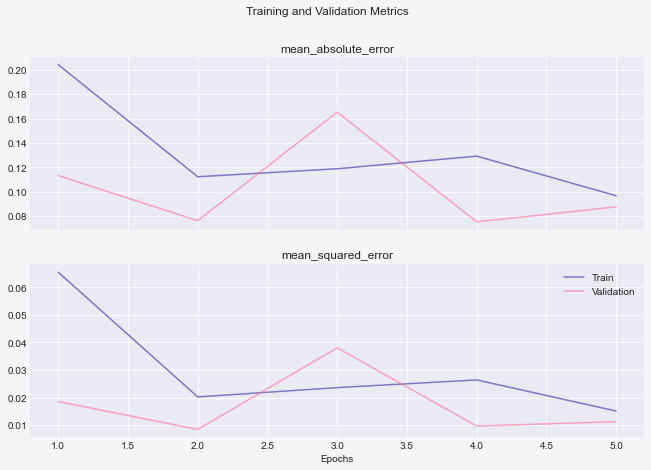

In [41]:
hist_plotter(lstm_100x2_hst.history)

### 1 Layer, 250 Cells

In [42]:
lstm_250x1 = make_lstm(neurons=250, layers=1,**model_kwg)
lstm_250x1, lstm_250x1_hst = fit_model(model=lstm_250x1, **modelfit_kwg)
lstm_250x1.summary()

Epoch 1/5
154/154 [==============================] - 19s 123ms/step - loss: 0.0600 - mean_absolute_error: 0.1939 - mean_squared_error: 0.0600 - val_loss: 0.0067 - val_mean_absolute_error: 0.0684 - val_mean_squared_error: 0.0067
Epoch 2/5
154/154 [==============================] - 16s 106ms/step - loss: 0.0169 - mean_absolute_error: 0.1009 - mean_squared_error: 0.0169 - val_loss: 0.0206 - val_mean_absolute_error: 0.1217 - val_mean_squared_error: 0.0206
Epoch 3/5
154/154 [==============================] - 18s 116ms/step - loss: 0.0251 - mean_absolute_error: 0.1255 - mean_squared_error: 0.0251 - val_loss: 0.0075 - val_mean_absolute_error: 0.0704 - val_mean_squared_error: 0.0075
Epoch 4/5
154/154 [==============================] - 19s 122ms/step - loss: 0.0205 - mean_absolute_error: 0.1127 - mean_squared_error: 0.0205 - val_loss: 0.0511 - val_mean_absolute_error: 0.1864 - val_mean_squared_error: 0.0511
Epoch 5/5
154/154 [==============================] - 18s 117ms/step - loss: 0.0185 - mea

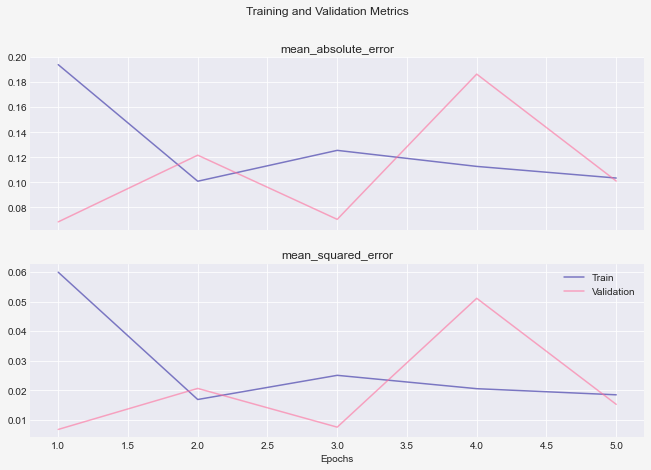

In [43]:
hist_plotter(lstm_250x1_hst.history)

# Compare Models

In [44]:
train_df, test_df = data_split(data=copper_scaled, return_dfs=True)
train_df.tail()

,base,dayofyr,snowfall
2335,-0.037337,-0.160976,-1.000000
2336,0.008953,-0.156098,-1.000000
2337,0.008953,-0.151220,-0.894737
2338,0.008953,-0.146341,-1.000000
2339,0.008953,-0.141463,-0.578947


In [143]:
def unscale_predictions(y, scaler):
    predictions_scaled_padded = np.zeros(shape=(y.shape[0], 3))
    y_len = y.shape[0]
    predictions_scaled_padded[:, 0] = y[:y_len,0]
    return scaler.inverse_transform(predictions_scaled_padded)[:, 0]

def get_predictions(model, data, lookback):
    yhat = model.predict(data)
    pad = np.zeros(shape=(lookback, 1))
    pad[:] = np.NaN 
    return np.concatenate([pad, yhat])

In [144]:
copper_predictions_scaled = get_predictions(lstm_250x1, Xy_val, lookback)
copper_predictions = unscale_predictions(y=copper_predictions_scaled, scaler=copper_scaler)

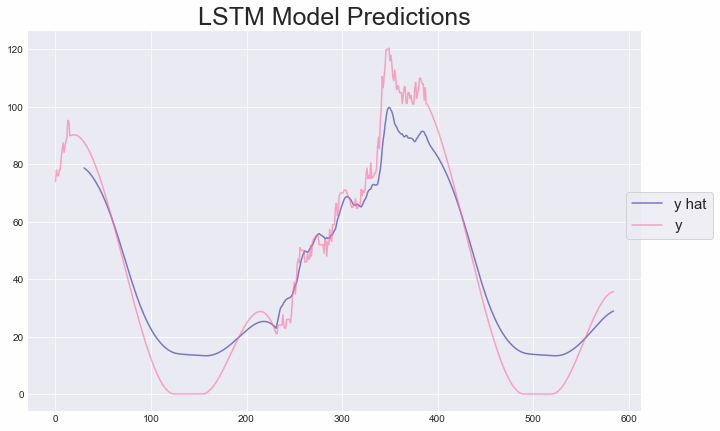

In [148]:
fig, ax = plt.subplots()
plt.plot(copper_predictions, label="y hat")
copper_unscaled_val = unscale_predictions(test_df.base.to_numpy().reshape(-1,1),
                                          copper_scaler)
plt.plot(copper_unscaled_val, label="y")
fig.legend(loc='right',  prop={'size': 15}, frameon=True)
ax.set_title("LSTM Model Predictions", size=25);